# Analysis of Scaevola Tracks

## Importing Dependencies and Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import cv2
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import scipy.signal as scipysignal
import matplotlib
import scipy.stats as stats
import warnings; warnings.simplefilter('ignore')
import math
matplotlib.rc('font',family='Arial')

min_frames = 120
ppmm = 198/60
fps=60

In [2]:
def cal_direction(x0,y0,x1,y1,x2,y2):
    ax, ay = (x2-x1) , (y2-y1)
    bx, by = (x0-x1) , (y0-y1)
    s = ax*by - ay*bx
    c = ax*bx + ay*by
    
    if((s ==0)& (c>0)):
        theta0 = 180
    elif ((s>0) & (c==0)):
        theta0 = -90
    elif ((s == 0) & (c<0)):
        theta0 = 0
    elif ((s < 0) & (c==0)):
        theta0 = 90
    else:
        theta0 = np.rad2deg(np.arctan(s/c))
        
    if((s > 0)& (c>0)): #hari
        theta = theta0 - 180
    elif ((s>0) & (c < 0)): #checked
        theta = theta0 
    elif ((s < 0) & (c<0)): #checked
        theta = theta0
    elif ((s < 0) & (c > 0)): # checked
        theta = 180+ theta0
    else:
        theta = theta0
        
    return theta

## Import Data

In [3]:
bee_path = pd.DataFrame()
frameN = []
file_name = [1,2,3,4]
num_bees = 0
for fn in file_name:
    if ((fn==3)| (fn==2)):
        bee_file = np.arange(1,13,1)
    elif (fn==1):
        bee_file = np.arange(1,21,1)
    elif (fn==4):
        bee_file = np.arange(1,12,1)
    
    for f in bee_file:
        bee_path1 = pd.read_csv('Scaevola_tracks/SV_%d'%(fn)+'_'+str(f)+'.csv')
        if (len(bee_path1.x0)>=min_frames):
            frameN = np.append(frameN,len(bee_path1)) 
            bee_path1 = bee_path1.rename(columns={'Unnamed: 0': 'beeN_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'nframe': 'nframe_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x0': 'x0_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y0': 'y0_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'area': 'area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x': 'x_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y': 'y_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'occlusion': 'occlusion_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sx': 'sx_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sy': 'sy_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'method': 'method_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'px': 'px_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'py': 'py_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x0i': 'x0i_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y0i': 'y0i_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sx11': 'sx11_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sy11': 'sy11_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'speed': 'speed_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'speeds': 'speeds_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'angle': 'angle_%d'%(fn)+str(f)})
            bee_path1 = bee_path1.rename(columns={'delta_area': 'delta_area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'mse_area': 'mse_area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'state': 'state_%d'%(fn)+str('%02d' %f)})
            
            num_bees+=1

            bee_path = pd.concat([bee_path, bee_path1], axis=1)

bee_path.head()    

,beeN_101,Unnamed: 0.1,nframe_101,x0_101,y0_101,area_101,x_101,y_101,occlusion_101,sx_101,...,x0i_411,y0i_411,sx11_411,sy11_411,speed_411,speeds_411,angle_411,delta_area_411,mse_area_411,state_411
0,0.0,0.0,58.0,1908.000000,552.500000,NaN,1908.000000,552.500000,0.0,1908.000000,...,971.000000,523.000000,971.000000,523.000000,NaN,NaN,NaN,NaN,NaN,Int_detection
1,1.0,1.0,59.0,1910.000000,553.000000,NaN,1910.000000,553.000000,0.0,1909.000000,...,976.825256,532.437927,973.912628,527.718964,11.090901,5.545450,NaN,NaN,NaN,0
2,2.0,2.0,60.0,1910.500000,552.500000,NaN,1910.500000,552.500000,0.0,1909.500000,...,977.323425,536.294067,975.049561,530.577332,3.888186,3.076180,-9.993146,NaN,NaN,0
3,3.0,3.0,61.0,1904.196655,554.778992,534.012034,1904.196655,554.778992,0.0,1908.232218,...,978.014771,535.437744,975.790863,531.792435,1.100567,4.759838,7.732113,NaN,NaN,0
4,4.0,4.0,62.0,1903.417603,554.929382,574.276577,1903.417603,554.929382,0.0,1906.038086,...,978.982117,533.666382,976.429114,532.167224,2.018287,0.827389,30.913439,NaN,NaN,0


In [4]:
beesnum = np.zeros(shape=(0,0))
for r in range(1000):
    if 'x0_'+str(r) in bee_path.columns:
        beesnum = np.append(beesnum,r)
beesnum = beesnum.astype(int)



In [5]:
all_bees = pd.DataFrame()
for fn in file_name:
    if ((fn==3)| (fn==2)):
        bee_file = np.arange(1,13,1)
    elif (fn==1):
        bee_file = np.arange(1,21,1)
    elif (fn==4):
        bee_file = np.arange(1,12,1)
    
    for f in bee_file:
        all_bees1 = pd.read_csv('Scaevola_tracks/SV_%d'%(fn)+'_'+str(f)+'.csv')
        if (len(all_bees1.x0)>=min_frames):
            all_bees = all_bees.append(all_bees1, ignore_index = True)
            

## Plot Tracks

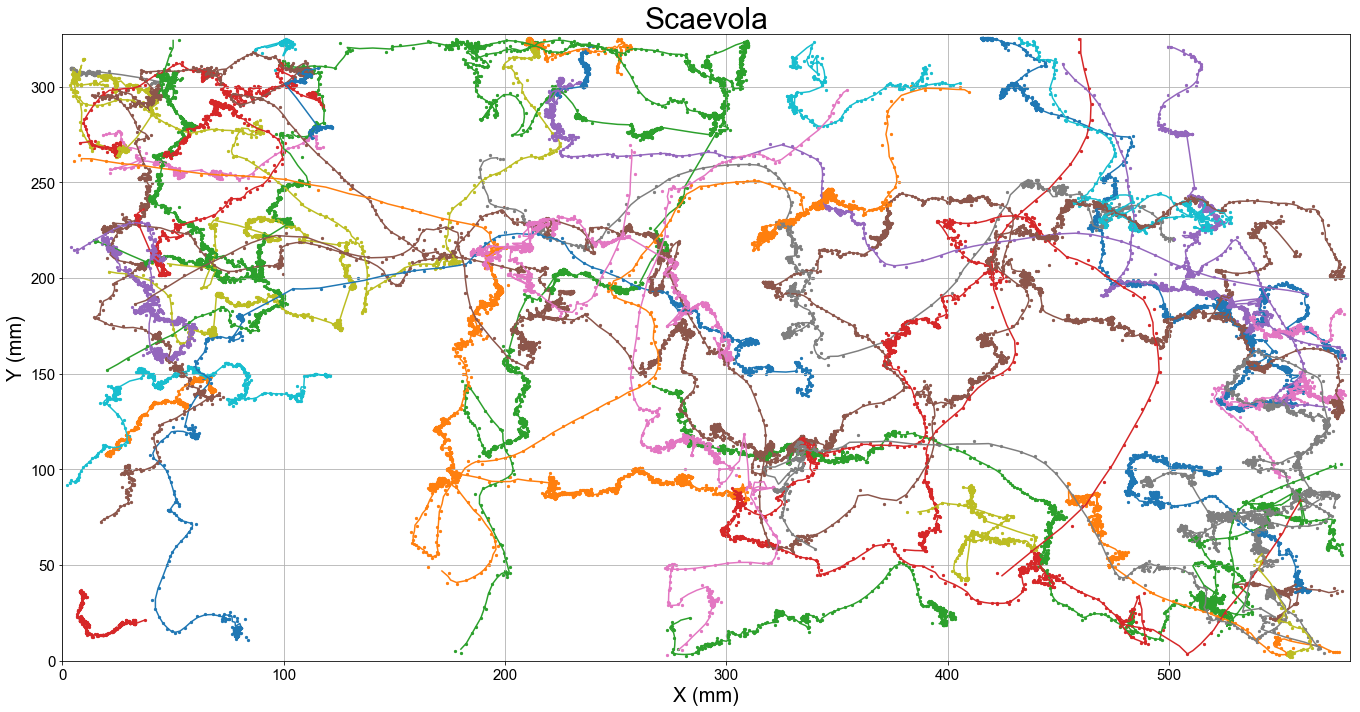

In [6]:
plt.figure(figsize=(19,10))
for bn in beesnum:
    #Y-axis is adjested to Matplotlib
    plt.scatter((bee_path['x0_%d'%(bn)]/ppmm), ((1080-bee_path['y0_%d'%(bn)])/ppmm), label = (bn), s=5 ) 
    plt.plot((bee_path['sx_%d'%(bn)]/ppmm), ((bee_path['sy_%d'%(bn)])/ppmm), label='_nolegend_')
    
plt.grid()
plt.xlim(0,1920/ppmm)
plt.ylim(0,1080/ppmm)
plt.title('Scaevola', fontsize=30)
plt.xlabel('X (mm)', fontsize=20)
plt.ylabel('Y (mm)', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.savefig('Scaevola_graphs/Scaevola_tracks.png', format='png', dpi=600)
plt.show()

## Plot Heatmap

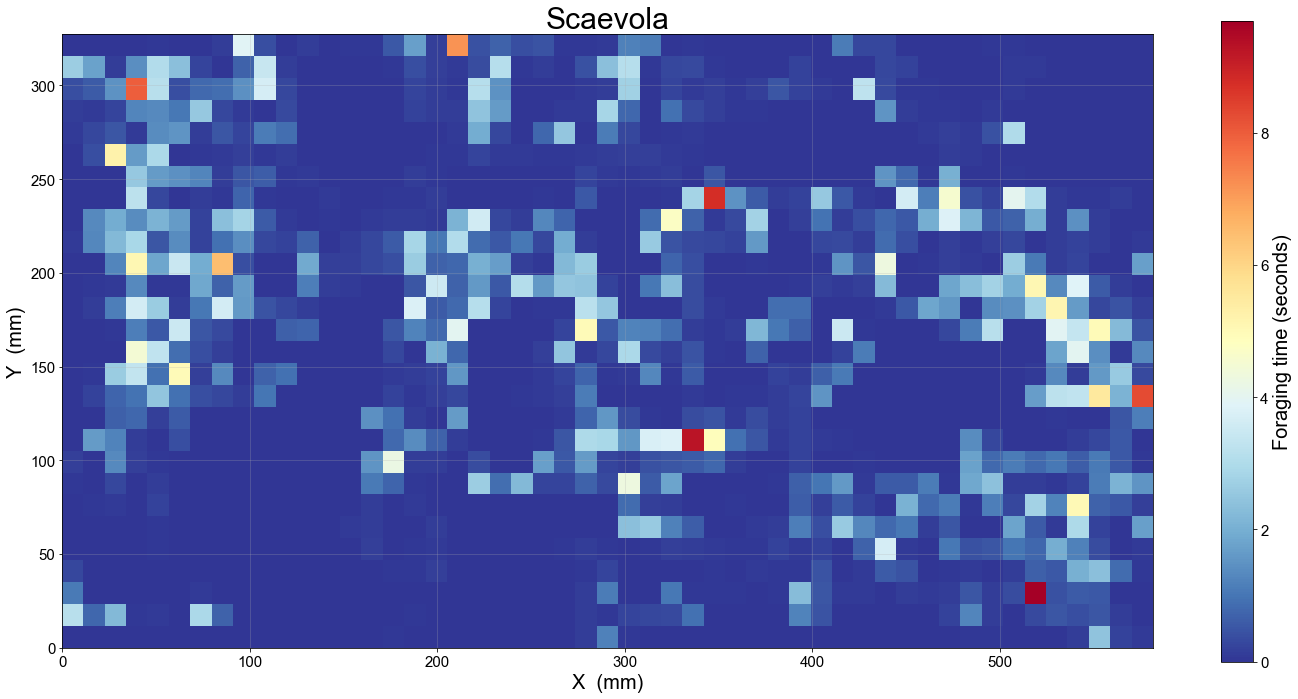

In [7]:
plt.figure(figsize=(20,10))
heatmap, xedges, yedges = np.histogram2d((all_bees['y0']/ppmm).dropna(),(all_bees['x0']/ppmm).dropna(), bins=(28,51), range = [[0, 1080/ppmm], [0, 1920/ppmm]])
extent = [yedges[0], yedges[-1],xedges[0], xedges[-1]]

plt.grid(alpha =0.3)
plt.xlim(0,1920/ppmm)
plt.ylim(0,1080/ppmm)
plt.title('Scaevola', fontsize=30)
# plt.suptitle('(29731 Frames | 8:15 minutes)',y = -0.0001, x= 0.1)
plt.xlabel('X  (mm)', fontsize=20)
plt.ylabel('Y  (mm)', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.imshow(heatmap/fps, interpolation='none',extent=extent,cmap='RdYlBu_r')
# plt.colorbar(label = 'Foraging time (seconds)')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(label = 'Foraging time (seconds)', fontsize=20)
plt.tight_layout()

plt.savefig('Scaevola_graphs/Scaevola_heatmap.png', format='png', dpi=600)

plt.show()

## Plot Distribution of Speed

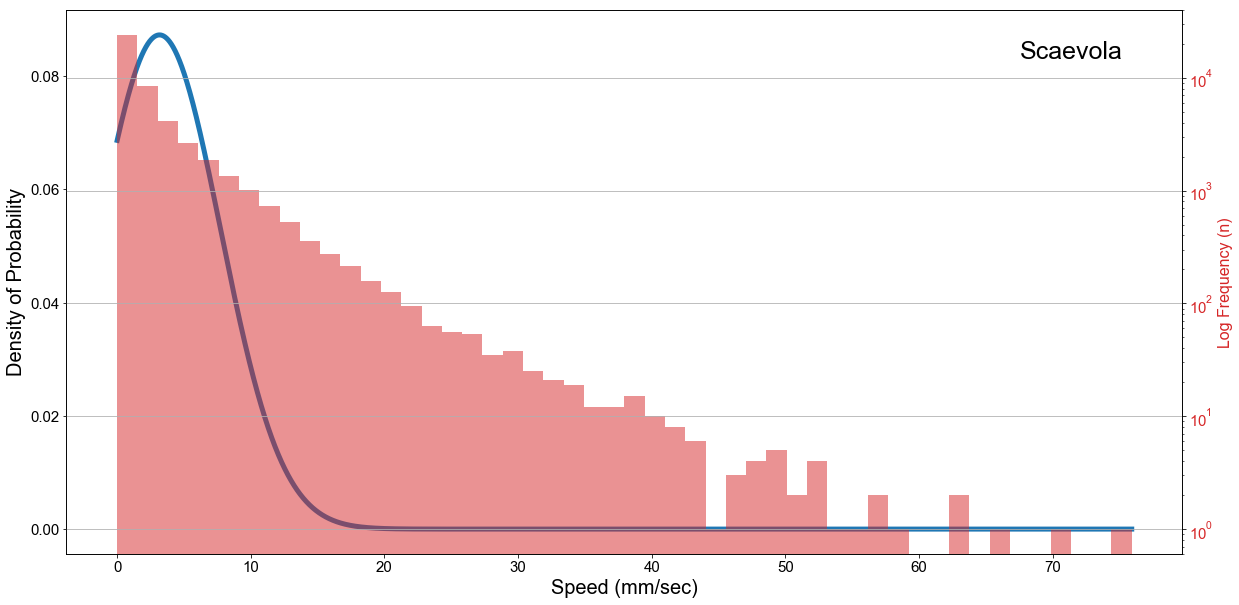

In [8]:
fig = plt.figure(figsize=(20,10))
speed = all_bees['speed'].dropna()
speed_pdf = stats.norm.pdf(sorted(speed), np.mean(speed), np.std(speed))
plt.plot(sorted(speed),speed_pdf, linewidth =5, alpha = 1)
plt.xlabel('Speed (mm/sec)', fontsize=20,fontname="Arial")
plt.ylabel('Density of Probability', fontsize=20,fontname="Arial")
plt.xticks(fontsize=15,fontname="Arial")
plt.yticks(fontsize=15,fontname="Arial")
plt.title('Scaevola', fontsize=25, x=0.9,y=0.9,fontname="Arial")

ax2 = plt.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Frequency (n)', color=color,fontsize=16,fontname="Arial")  # we already handled the x-label with ax1
ax2.hist(speed, log=True, stacked = False, histtype='bar', normed = False , bins=50, color = color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color,labelsize=15)

plt.grid()
plt.savefig('Scaevola_graphs/Scaevola_speed.png', format='png', dpi=450)

plt.show()

## Plot Distribution of Turn-angle

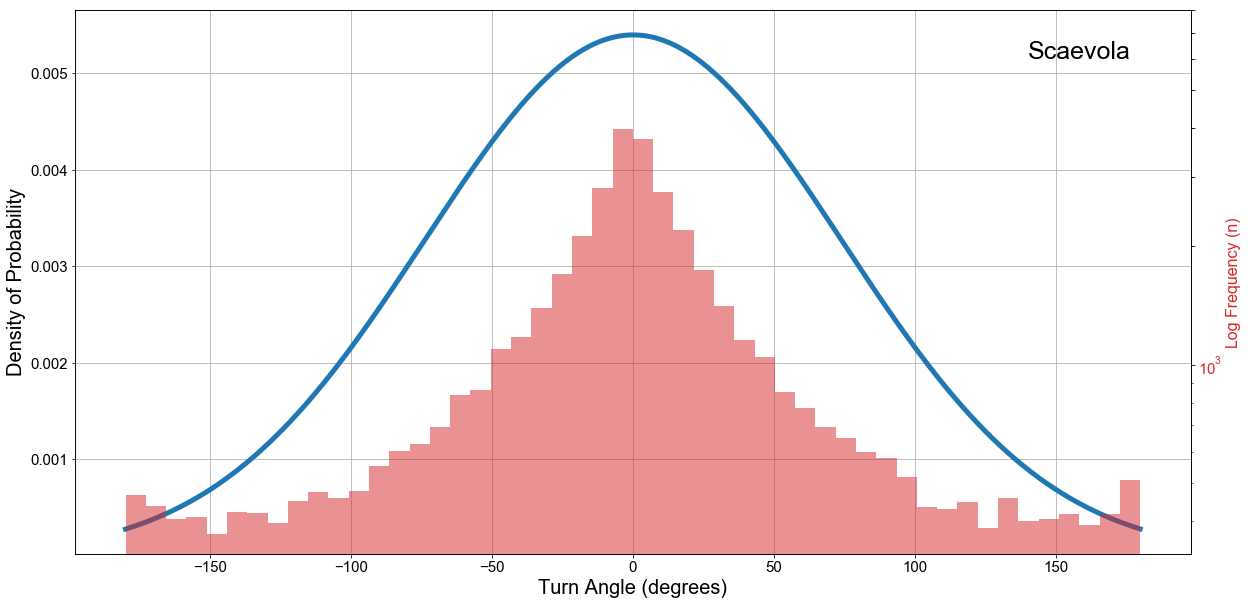

In [9]:
fig = plt.figure(figsize=(20,10))

angle = all_bees['angle'].dropna()
angle_pdf = stats.norm.pdf(sorted(angle), np.mean(angle), np.std(angle))
plt.plot(sorted(angle),angle_pdf, linewidth =5)
plt.xlabel('Turn Angle (degrees)', fontsize=20,fontname="Arial")
plt.ylabel('Density of Probability', fontsize=20,fontname="Arial")
plt.title('Scaevola', fontsize=25, x=0.9,y=0.9,fontname="Arial")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
ax2 = plt.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Frequency (n)', color=color,fontsize=16,fontname="Arial" )  # we already handled the x-label with ax1
ax2.hist(angle, log=True, stacked = False, histtype='bar', normed = False , bins=50, color = color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color,labelsize=15)
ax2.set_yticks([1000,2000,3000,4000,5000,6000,7000,8000])
plt.savefig('Scaevola_graphs/Scaevola_turnangle.png', format='png', dpi=450)

plt.show()

## Plot Honeybee Position

In [10]:
bee_details =  pd.DataFrame(columns=['bee_num' , 'nframes', 'recorded', 'under_carpet', 'BS', 'DL','speed_mean', 'speed_max','distance'])
for bn in beesnum:
    nframes = bee_path['nframe_'+str(bn)].count()
    recorded = bee_path['x0_'+str(bn)].count()
    BS = bee_path['area_'+str(bn)].count()
    speed_mean =bee_path['speed_'+str(bn)].mean()
    speed_max =bee_path['speed_'+str(bn)].max() 
    distance =bee_path['speed_'+str(bn)].sum() 
    under_carpet = bee_path['nframe_'+str(bn)][bee_path['state_'+str(bn)] == '1'].count()
    DL = recorded - BS
    bn = str(bn)
    
    newdata = [bn, nframes, recorded, under_carpet, BS, DL, speed_mean, speed_max, distance]
    bee_details.loc[len(bee_details)] = newdata

bee_details
mean_time = bee_details.nframes.mean()/fps


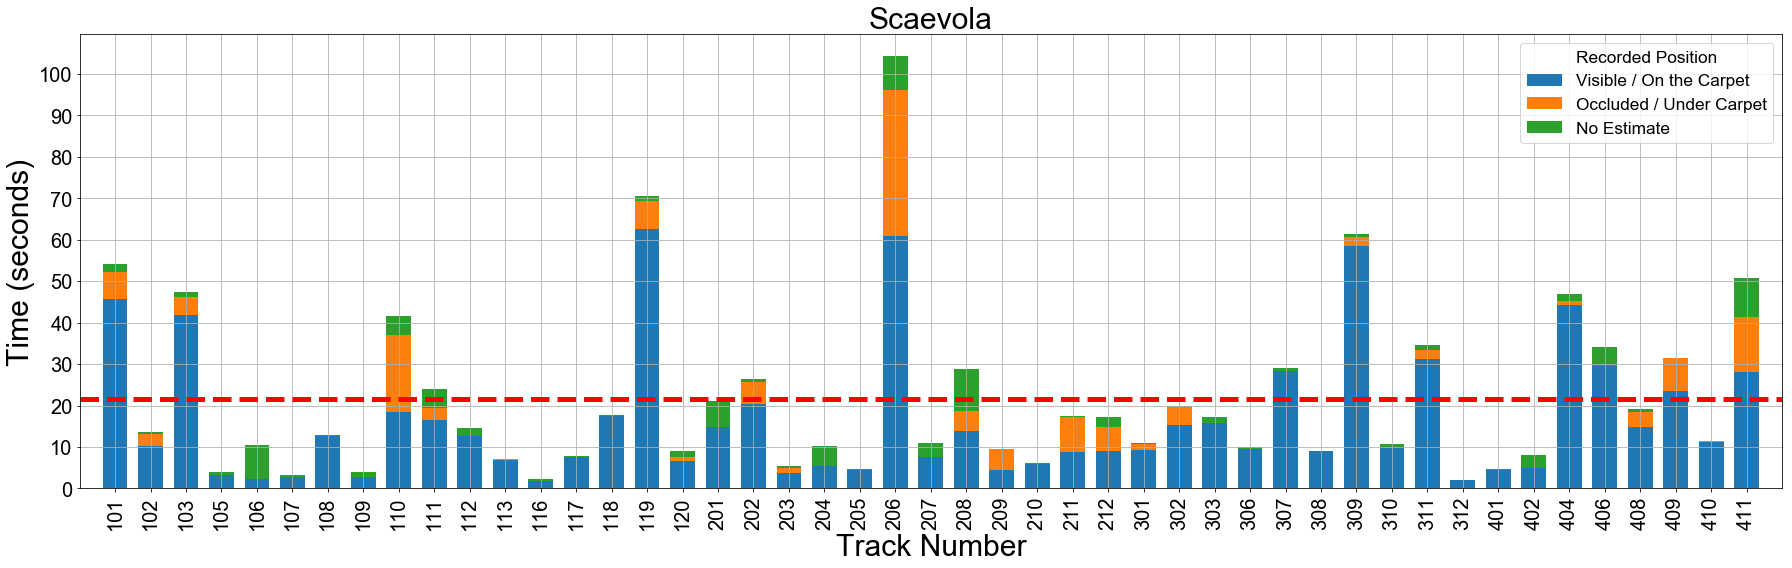

In [11]:
plt.figure(figsize=(25,8))
p1 = plt.bar(bee_details.bee_num, bee_details.recorded/fps, width = 0.7, align='center')
p2 = plt.bar(bee_details.bee_num, bee_details.under_carpet/fps, width = 0.7, align='center', bottom = (bee_details.recorded/60))
p3 = plt.bar(bee_details.bee_num, (bee_details.nframes-bee_details.recorded-bee_details.under_carpet)/60, width = 0.7, align='center', bottom = (bee_details.recorded+bee_details.under_carpet)/60)
plt.grid()
plt.xlim(-1,47)
plt.title('Scaevola', fontsize=30,fontname="Arial")
plt.xlabel('Track Number', fontsize=30,fontname="Arial")
plt.ylabel('Time (seconds)', fontsize=30,fontname="Arial")
plt.xticks(rotation='vertical', fontsize = 20,fontname="Arial")
plt.yticks(np.arange(0,110,10), fontsize = 20,fontname="Arial")
# 
ax2 = plt.gca()
color = 'tab:red'
ax2.plot([-1,47],[mean_time,mean_time], color = 'r', linewidth = 5, linestyle = '--', label = 'cc')
plt.legend((p1[0], p2[0],p3[0]), ('Visible / On the Carpet', 'Occluded / Under Carpet','No Estimate'),title = 'Recorded Position', title_fontsize= 'xx-large' , fontsize = 'xx-large' )


plt.tight_layout()
plt.savefig('Scaevola_graphs/Scaevola_beeposition.png', format='png', dpi=600)
plt.show()

## Plot Detection Stats and Honeybee Position

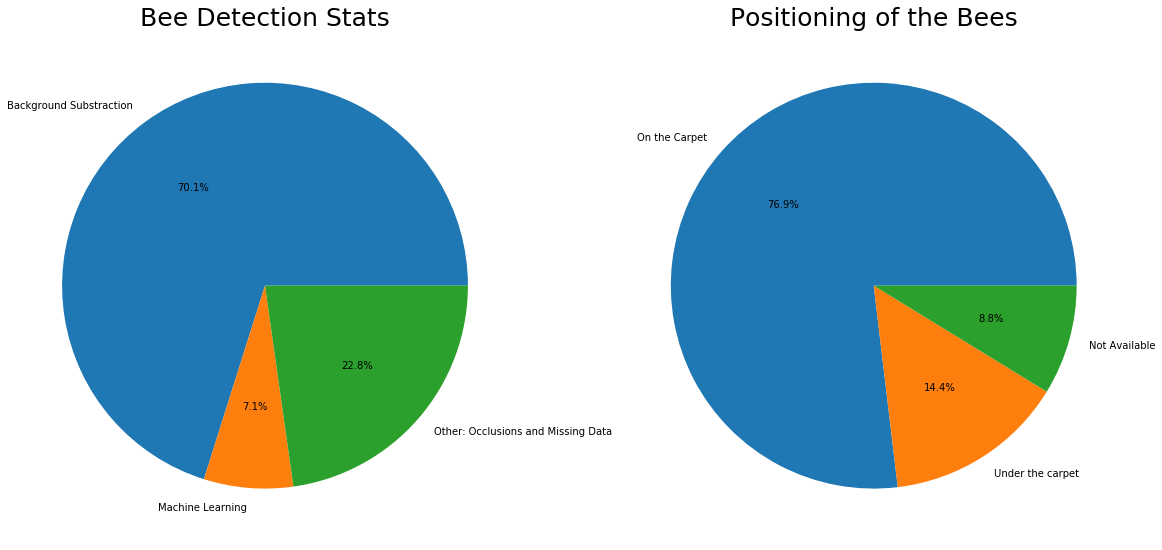

In [15]:
fig = plt.figure(figsize=(20,10))
BS_recorded = all_bees.area.count()
ML_recorded = all_bees.x0.count() - all_bees.area.count()
Not_recorded = all_bees.x0.last_valid_index() - all_bees.x0.count()
state_0 = all_bees.state[all_bees.state == '0'].count()
state_1 = all_bees.state[all_bees.state == '1'].count()
state_2 = all_bees.x0.last_valid_index() - (state_0+state_1)
    #Alg1
plt.subplot(121)
labels = 'Background Substraction', 'Machine Learning', 'Other: Occlusions and Missing Data'
sizes = [BS_recorded, ML_recorded, Not_recorded]
plt.title('Bee Detection Stats', fontsize=25)
plt.pie(sizes, labels=labels,  autopct='%1.1f%%')

plt.subplot(122)
labels1 = 'On the Carpet', 'Under the carpet', 'Not Available'
sizes1 = [state_0, state_1, state_2]
plt.title('Positioning of the Bees', fontsize=25)
plt.pie(sizes1, labels=labels1,  autopct='%1.1f%%')
plt.savefig('Scaevola_graphs/Scaevola_stats.pdf', format='pdf', dpi=600)
plt.show()